In [62]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.util.remote import Remote

from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.operators.sampling.rnd import FloatRandomSampling,IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
import math
import copy
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler
from keras.layers import Dropout

In [63]:
# Criptomoedas que vamos escolher para nosso portifólio
cryptos = [
    'BTC-USD', 'ETH-USD','LTC-USD', 'ADA-USD',
    'DOT-USD', 'LINK-USD','SOL-USD',
    'TRX-USD'
]

In [64]:
data_visual = {}
for crypto in cryptos:
    data_visual[crypto] = pd.read_csv(f"{crypto}.csv", index_col='Date')
    data_visual[crypto] = data_visual[crypto]

In [78]:
df = data_visual['SOL-USD']
df['ae'] = df['exp_value'] - df['Crypto_Return_Today']
df['ae'] = abs(df['ae'])
df['mae'] = df['ae'].rolling(window = 50).mean()

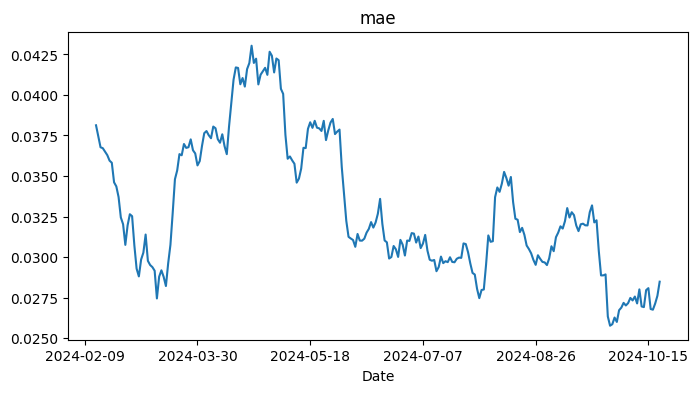

In [79]:
from matplotlib import pyplot as plt
df['mae'].plot(kind='line', figsize=(8, 4), title='mae')
plt.gca().spines[['top', 'right']].set_visible(True)

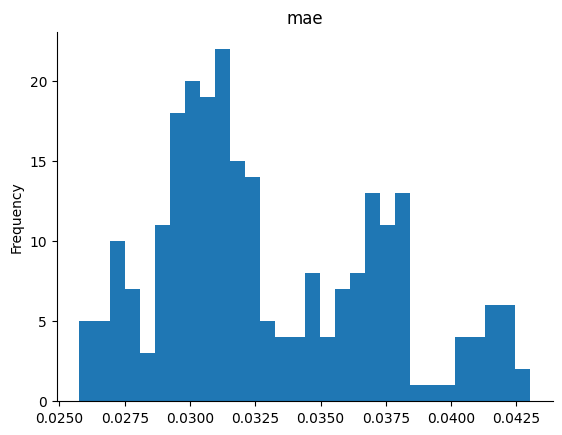

In [80]:
from matplotlib import pyplot as plt
df['mae'].plot(kind='hist', bins=30, title='mae')
plt.gca().spines[['top', 'right',]].set_visible(False)

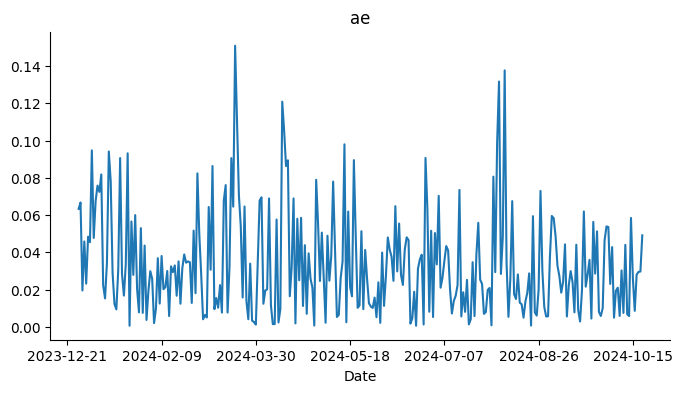

In [81]:
from matplotlib import pyplot as plt
df['ae'].plot(kind='line', figsize=(8, 4), title='ae')
plt.gca().spines[['top', 'right']].set_visible(False)

### **Vamos criar data2**
#### Este será um dicionário que lê os csv's salvos e os armazena para cada criptomoeda

In [9]:
data2 = {}
for crypto in cryptos:
    data2[crypto] = pd.read_csv(f"{crypto}.csv", index_col='Date')
    #data_complete[crypto] = pd.read_csv(f"{crypto}.csv")

In [10]:
for crypto in cryptos:
    print(len(data2[crypto]))
    data2[crypto] = data2[crypto][:-110]


2983
2538
2983
2538
1523
2538
1655
2538


In [11]:
data2['BTC-USD']

,Crypto_Return_Today,exp_value
Date,,
2016-08-21,-0.001085,NaN
2016-08-22,0.009318,NaN
2016-08-23,-0.005736,NaN
2016-08-24,-0.005552,NaN
2016-08-25,-0.004178,NaN
...,...,...
2024-06-28,-0.021204,-0.004015
2024-06-29,0.009364,-0.001183
2024-06-30,0.028972,-0.004116


### **Vamos criar data_mus**
#### Este será um DataFrame que cada linha representa uma sample, e cada coluna representa o valor esperado de um dos ativos de nosso portifólio.

In [12]:
data_mus = pd.DataFrame()
for crypto in cryptos:
    data_mus = pd.merge(data_mus, data2[crypto]['exp_value'], left_index=True, right_index=True, how='outer', suffixes=('', crypto))

In [13]:
#data_mus.fillna(0, inplace=True)
data_mus = data_mus.rename(columns={'exp_value': 'exp_valueBTC-USD'})
data_mus

,exp_valueBTC-USD,exp_valueETH-USD,exp_valueLTC-USD,exp_valueADA-USD,exp_valueDOT-USD,exp_valueLINK-USD,exp_valueSOL-USD,exp_valueTRX-USD
Date,,,,,,,,
2016-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-08-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-06-28,-0.004015,-0.000156,0.004506,-0.002143,-0.031004,-0.009725,-0.004193,0.001434
2024-06-29,-0.001183,-0.004761,-0.007724,-0.005451,-0.003152,-0.007116,-0.006054,0.004159
2024-06-30,-0.004116,-0.001951,-0.004314,-0.006808,-0.001001,-0.006569,-0.006372,0.002396


### **Vamos criar data_reals**
#### Este será um DataFrame que cada linha representa uma sample, e cada coluna representa o valor real de um dos ativos de nosso portifólio.

In [14]:
data_reals = pd.DataFrame()
for crypto in cryptos:
    data_reals = pd.merge(data_reals, data2[crypto]['Crypto_Return_Today'], left_index=True, right_index=True, how='outer', suffixes=('', crypto))

In [15]:
data_reals = data_reals.rename(columns={'Crypto_Return_Today': 'Crypto_Return_TodayBTC-USD'})
data_reals

,Crypto_Return_TodayBTC-USD,Crypto_Return_TodayETH-USD,Crypto_Return_TodayLTC-USD,Crypto_Return_TodayADA-USD,Crypto_Return_TodayDOT-USD,Crypto_Return_TodayLINK-USD,Crypto_Return_TodaySOL-USD,Crypto_Return_TodayTRX-USD
Date,,,,,,,,
2016-08-21,-0.001085,NaN,-0.001200,NaN,NaN,NaN,NaN,NaN
2016-08-22,0.009318,NaN,0.010953,NaN,NaN,NaN,NaN,NaN
2016-08-23,-0.005736,NaN,0.070155,NaN,NaN,NaN,NaN,NaN
2016-08-24,-0.005552,NaN,-0.018953,NaN,NaN,NaN,NaN,NaN
2016-08-25,-0.004178,NaN,-0.014212,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-06-28,-0.021204,-0.021078,-0.004960,-0.013614,-0.017038,-0.044705,-0.067469,0.009084
2024-06-29,0.009364,-0.000214,0.029200,-0.003769,-0.016743,-0.018125,0.002079,0.019098
2024-06-30,0.028972,0.017577,0.004913,0.021192,0.022246,0.053903,0.045241,-0.006452


### **Vamos criar  mus e reals**
#### mus será um dicionário, cujas chaves são as datas que compõe o index de data_mus, e cada item é um numpy array de 8 elementos (representando as criptomoedas) e 1 ultimo elemento representando o RFR
#### reals será um dicionário cujas chaves são as datas que compõe do index de data_mus, e cada item é um np array de 8 elementos (representando as criptomoedas) e 1 ultimo elemento representando o RFR
##### *Importante!* - Vamos fazer de tal modo que, para os arrays com valores NaN, nós removemos ele do portifólio

In [16]:
data_reals_with_RFR = data_reals.copy()
data_reals_with_RFR['RFR'] = 0.00031
data_reals_with_RFR

,Crypto_Return_TodayBTC-USD,Crypto_Return_TodayETH-USD,Crypto_Return_TodayLTC-USD,Crypto_Return_TodayADA-USD,Crypto_Return_TodayDOT-USD,Crypto_Return_TodayLINK-USD,Crypto_Return_TodaySOL-USD,Crypto_Return_TodayTRX-USD,RFR
Date,,,,,,,,,
2016-08-21,-0.001085,NaN,-0.001200,NaN,NaN,NaN,NaN,NaN,0.00031
2016-08-22,0.009318,NaN,0.010953,NaN,NaN,NaN,NaN,NaN,0.00031
2016-08-23,-0.005736,NaN,0.070155,NaN,NaN,NaN,NaN,NaN,0.00031
2016-08-24,-0.005552,NaN,-0.018953,NaN,NaN,NaN,NaN,NaN,0.00031
2016-08-25,-0.004178,NaN,-0.014212,NaN,NaN,NaN,NaN,NaN,0.00031
...,...,...,...,...,...,...,...,...,...
2024-06-28,-0.021204,-0.021078,-0.004960,-0.013614,-0.017038,-0.044705,-0.067469,0.009084,0.00031
2024-06-29,0.009364,-0.000214,0.029200,-0.003769,-0.016743,-0.018125,0.002079,0.019098,0.00031
2024-06-30,0.028972,0.017577,0.004913,0.021192,0.022246,0.053903,0.045241,-0.006452,0.00031


In [36]:
i = 2750
df2 = data_mus[i:i+1]
df1 = data_reals[0:i]
df2

,exp_valueBTC-USD,exp_valueETH-USD,exp_valueLTC-USD,exp_valueADA-USD,exp_valueDOT-USD,exp_valueLINK-USD,exp_valueSOL-USD,exp_valueTRX-USD
Date,,,,,,,,
2024-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
cols_with_nan_in_df2 = df2.isna().any()
# Remover do df1 as colunas que possuem NaN em df2
df1_cleaned = df1.drop(columns=df1.columns[cols_with_nan_in_df2])

df2 = df2.dropna(axis=1)
cols_with_nan_in_df2

exp_valueBTC-USD     True
exp_valueETH-USD     True
exp_valueLTC-USD     True
exp_valueADA-USD     True
exp_valueDOT-USD     True
exp_valueLINK-USD    True
exp_valueSOL-USD     True
exp_valueTRX-USD     True
dtype: bool

In [34]:
df1_cleaned

,Crypto_Return_TodayBTC-USD,Crypto_Return_TodayETH-USD,Crypto_Return_TodayLTC-USD,Crypto_Return_TodayADA-USD,Crypto_Return_TodayDOT-USD,Crypto_Return_TodayLINK-USD,Crypto_Return_TodaySOL-USD,Crypto_Return_TodayTRX-USD
Date,,,,,,,,
2016-08-21,-0.001085,NaN,-0.001200,NaN,NaN,NaN,NaN,NaN
2016-08-22,0.009318,NaN,0.010953,NaN,NaN,NaN,NaN,NaN
2016-08-23,-0.005736,NaN,0.070155,NaN,NaN,NaN,NaN,NaN
2016-08-24,-0.005552,NaN,-0.018953,NaN,NaN,NaN,NaN,NaN
2016-08-25,-0.004178,NaN,-0.014212,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-06-05,0.007264,0.013469,0.020793,-0.000672,0.008496,0.000878,0.009737,0.001423
2024-06-06,-0.004592,-0.013720,-0.014529,-0.006686,-0.014834,-0.026805,-0.020185,0.000977
2024-06-07,-0.020223,-0.035526,-0.049838,-0.018634,-0.070209,-0.056044,-0.045170,-0.017903


In [ ]:
covs = {}
mus = {}
reals = {}

for i in range(100, data_mus.shape[0], 1):
    if(i < 200):
        df1 = data_reals[0:i]
        df2 = data_mus[i:i+1]
        cols_with_nan_in_df2 = df2.isna().any()
        # Remover do df1 as colunas que possuem NaN em df2
        df1_cleaned = df1.drop(columns=df1.columns[cols_with_nan_in_df2])
        df2_cleaned = df2.dropna(axis=1)
    else:


In [166]:
covs = {}
for i in range(100, data_mus.shape[0], 1):
    df = pd.DataFrame()
    if(i < 200):
        df = data_reals_with_RFR.iloc[0: i].dropna(axis = 1)
    else:
        df = data_reals_with_RFR.iloc[i-200: i].dropna(axis = 1)
    date = data_reals_with_RFR.index[i]

    covs[date] = df.cov().to_numpy()

In [1]:
pd.DataFrame(covs['2017-09-04'])

NameError: name 'pd' is not defined

In [ ]:
reals = {}
mus = {}

for i in range(100, data_mus.shape[0], 1):
    date = data_reals_with_RFR.index[i]
    
    for crypto in cryptos:
        if date in data2[crypto].index:
            if data2[crypto].
            reals[date] = np.append(reals[date], 1)

In [48]:
reals = {}
mus = {} # mus[date] será um numpy array de K elementos
for i in range(data_mus.shape[0]):
    date = data_mus.index[i]

    mus[date] = data_mus.iloc[i].to_numpy()
    reals[date] = data_reals.iloc[i].to_numpy()

    
    reals[date] = reals[date][~np.isnan(mus[date])]
    mus[date] = mus[date][~np.isnan(mus[date])]

    mus[date] = np.exp(mus[date]) - 1
    reals[date] = np.exp(reals[date]) - 1

    reals[date] = np.append(reals[date], 0.00031)
    mus[date] = np.append(mus[date], 0.00031)

In [49]:
i = 0
date = data_mus.index[i]
mus[date]

array([0.00031])

In [39]:
"""reals = {} # mus[date] será um numpy array de 8 elementos
for i in range(data_reals.shape[0]):
    date = data_reals.index[i]
    reals[date] = data_reals.iloc[i].to_numpy()
    reals[date] = reals[date][~np.isnan(reals[date])]
    reals[date] = np.append(reals[date], 0.002)"""

'reals = {} # mus[date] será um numpy array de 8 elementos\nfor i in range(data_reals.shape[0]):\n    date = data_reals.index[i]\n    reals[date] = data_reals.iloc[i].to_numpy()\n    reals[date] = reals[date][~np.isnan(reals[date])]\n    reals[date] = np.append(reals[date], 0.002)'

In [50]:
for i in range(data_reals.shape[0]):
    date = data_reals.index[i]
    if len(reals[date]) != len(mus[date]):
        print("Ih Rapaz...   ", len(reals[date]), " ", len(mus[date]))

### **Vamos agora criar covs**
#### covs é um dicionário cujas chaves são as datas que compõe o data_mus, cada item é uma matriz de covariância 8x8 calculada a partir dos retornos reais dos ultimos 50 intervalos anteriores a aquela data
##### *caso não haja 50 dias anteriores nós calculamos a partir de todos anteriores msm*

In [71]:
for i in range(1, data_mus.shape[0]):
    date = data_mus.index[i]
    if covs[date].shape[0] != len(mus[date]):
        print("Ih Rapaz...   ", covs[date].shape[0], " ", len(mus[date]))

Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...    3   1
Ih Rapaz...  

In [72]:
for i in range(data_mus.shape[0]):
    date = data_mus.index[i]
    if covs[date].shape[0] != len(mus[date]):
        print("Ih Rapaz...   ", covs[date].shape[0], " ", len(mus[date]))

KeyError: '2016-08-21'

em cada dia: date

covs[date] é a matriz de covariancia


mus[date] é o vetor de valores preditos


reals[date] é o vetor de valores reais


isso gera um portifólio ws[date]


para esse portifólio, vamos ter como retorno percentual ws[date]*(e^mus[date] - 1) que vamos armazenar em profit[date]

In [ ]:
from pymoo.core.problem import ElementwiseProblem

class PortfolioProblemGA(ElementwiseProblem):
    def __init__(self, mu, cov, risk_free_rate=0.002, **kwargs):
        # Problema com apenas 1 objetivo. Minimizar a função objetivo _evaluate que é sharpe * -1
        super().__init__(n_var=8, n_obj=1, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu # @ é multiplicação de matriz 
        exp_risk = np.sqrt(x.T @ self.cov @ x) 
        sharpe = (exp_return - self.risk_free_rate) / exp_risk

        out["F"] = -sharpe #[exp_risk, -exp_return]
        # importante : Note o sinal negativo para Sharpe (queremos maximizar Sharpe), mas o pymoo esperar minimizar
        # 
        out["risk_return"] = [exp_risk, -exp_return]


from pymoo.core.repair import Repair

class PortfolioRepair(Repair): # Elimina pesos muito baixos (menores que 0.001)
    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0 # Seta valores menores que 0.001 (1e-3) para zero
        X=X / X.sum(axis=1, keepdims=True) # normaliza o portfolio (somatorio dos pesos igual a 1) 
        return X

In [ ]:
from pymoo.core.problem import ElementwiseProblem

class PortfolioProblemGA(ElementwiseProblem):
    def __init__(self, mu, cov, risk_free_rate=0.002, **kwargs):
        # Problema com apenas 1 objetivo. Minimizar a função objetivo _evaluate que é sharpe * -1
        super().__init__(n_var=8, n_obj=1, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu # @ é multiplicação de matriz 
        exp_risk = np.sqrt(x.T @ self.cov @ x) 
        sharpe = (exp_return - self.risk_free_rate) / exp_risk

        out["F"] = -sharpe #[exp_risk, -exp_return]
        # importante : Note o sinal negativo para Sharpe (queremos maximizar Sharpe), mas o pymoo esperar minimizar
        # 
        out["risk_return"] = [exp_risk, -exp_return]


from pymoo.core.repair import Repair

class PortfolioRepair(Repair): # Elimina pesos muito baixos (menores que 0.001)
    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0 # Seta valores menores que 0.001 (1e-3) para zero
        X=X / X.sum(axis=1, keepdims=True) # normaliza o portfolio (somatorio dos pesos igual a 1) 
        return X

In [ ]:
import os
def Portfolio(mu, cov, day):
    # Solução com GA
    problem = PortfolioProblemGA(mu, cov)


    algorithm = GA(
        pop_size=100,
        crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=PortfolioRepair()), # Simulated Binary Crossover, hyperparameters: prob of crossover, eta - parameter of crossover distribution
        mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=PortfolioRepair()),  
        eliminate_duplicates=True)

    res = minimize(problem, # observe que estamos minimizando
                algorithm,
                termination=('n_gen', 1000),# Criterio de termino: numero de geracoes!
                seed=1,
                verbose=False)
    
    # Apresentação dos Resultados
    #res.X: Design space values are
    #res.F: Objective spaces values

    X, F, sharpe = res.opt.get("X", "risk_return", "sharpe")
    F = F * [1, -1]
    max_sharpe = sharpe.argmax()

    plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
    plt.scatter(cov.diagonal() ** 0.5, mu, facecolor="none", edgecolors="black", s=30, label="Asset")
    plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
    plt.legend()
    plt.xlabel("expected volatility")
    plt.ylabel("expected return")
    plt.savefig(os.path.join(save_directory, f'portfolio_plot_{day}.png'), bbox_inches='tight')
    plt.close()  # Fecha a figura para liberar memória
    import operator

    allocation = {name: w for name, w in zip(cryptos, X[max_sharpe])}

    X, F, sharpe = res.opt.get("X", "risk_return", "sharpe")
    F = F * [1, -1]
    max_sharpe = sharpe.argmax()
    
    allocation = {name: w for name, w in zip(cryptos, X[max_sharpe])}

    pesos = []
    for name, w in allocation.items():
        pesos = np.append(pesos, w)
    return pesos


In [ ]:
# Define o caminho para salvar as imagens
global save_directory 
save_directory = "C:\\Users\\delve\OneDrive\\Eu\\GitHub\\Quantamental\\Código\\Plots"  # Altere para o caminho desejado
os.makedirs(save_directory, exist_ok=True)  # Cria a pasta se não existir


In [ ]:
for i in range(3, data_reals.shape[0], 1):
    date = data_reals.index[i]
    mus[date] = pd.DataFrame(mus[date]).fillna(-1).to_numpy().reshape((8,))
    covs[date] = pd.DataFrame(covs[date]).fillna(1).to_numpy()

In [ ]:
pesos = {}
for i in range(3, data_reals.shape[0], 1):
    date = data_reals.index[i]
    pesos[date] = Portfolio(mus[date], covs[date], i)
    print("Etapa ", i, " de ", data_reals.shape[0])

Etapa  3  de  374
Etapa  4  de  374
Etapa  5  de  374
Etapa  6  de  374
Etapa  7  de  374
Etapa  8  de  374
Etapa  9  de  374
Etapa  10  de  374
Etapa  11  de  374
Etapa  12  de  374
Etapa  13  de  374
Etapa  14  de  374
Etapa  15  de  374
Etapa  16  de  374
Etapa  17  de  374
Etapa  18  de  374
Etapa  19  de  374
Etapa  20  de  374
Etapa  21  de  374
Etapa  22  de  374
Etapa  23  de  374
Etapa  24  de  374
Etapa  25  de  374
Etapa  26  de  374
Etapa  27  de  374
Etapa  28  de  374
Etapa  29  de  374
Etapa  30  de  374
Etapa  31  de  374
Etapa  32  de  374
Etapa  33  de  374
Etapa  34  de  374
Etapa  35  de  374
Etapa  36  de  374
Etapa  37  de  374
Etapa  38  de  374
Etapa  39  de  374
Etapa  40  de  374
Etapa  41  de  374
Etapa  42  de  374
Etapa  43  de  374
Etapa  44  de  374
Etapa  45  de  374
Etapa  46  de  374
Etapa  47  de  374
Etapa  48  de  374
Etapa  49  de  374
Etapa  50  de  374
Etapa  51  de  374
Etapa  52  de  374
Etapa  53  de  374
Etapa  54  de  374
Etapa  55  de  374


C:\Users\delve\AppData\Local\Temp\ipykernel_29472\1630072497.py:13: RuntimeWarning: invalid value encountered in sqrt
  exp_risk = np.sqrt(x.T @ self.cov @ x)
C:\Users\delve\AppData\Local\Temp\ipykernel_29472\1630072497.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  sharpe = (exp_return - self.risk_free_rate) / exp_risk


Etapa  192  de  374
Etapa  193  de  374
Etapa  194  de  374
Etapa  195  de  374
Etapa  196  de  374
Etapa  197  de  374
Etapa  198  de  374
Etapa  199  de  374
Etapa  200  de  374
Etapa  201  de  374
Etapa  202  de  374
Etapa  203  de  374
Etapa  204  de  374
Etapa  205  de  374
Etapa  206  de  374
Etapa  207  de  374
Etapa  208  de  374
Etapa  209  de  374
Etapa  210  de  374
Etapa  211  de  374
Etapa  212  de  374
Etapa  213  de  374
Etapa  214  de  374
Etapa  215  de  374
Etapa  216  de  374
Etapa  217  de  374
Etapa  218  de  374
Etapa  219  de  374
Etapa  220  de  374
Etapa  221  de  374
Etapa  222  de  374
Etapa  223  de  374
Etapa  224  de  374
Etapa  225  de  374
Etapa  226  de  374
Etapa  227  de  374
Etapa  228  de  374
Etapa  229  de  374
Etapa  230  de  374
Etapa  231  de  374
Etapa  232  de  374
Etapa  233  de  374
Etapa  234  de  374
Etapa  235  de  374
Etapa  236  de  374
Etapa  237  de  374
Etapa  238  de  374
Etapa  239  de  374
Etapa  240  de  374
Etapa  241  de  374


In [ ]:
pd.DataFrame(pesos).T.to_csv('pesos1.csv', index=True)

In [ ]:
df = pd.read_csv('pesos1.csv', index_col = 0,  parse_dates=True)
df

,0,1,2,3,4,5,6,7
,,,,,,,,
2017-09-11,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000
2017-09-18,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000
2017-09-25,0.000000,0.003901,0.988343,0.0,0.0,0.002702,0.005054,0.000000
2017-10-02,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000
2017-10-09,0.777442,0.000000,0.222558,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2024-09-16,0.467230,0.000000,0.000000,0.0,0.0,0.000000,0.532770,0.000000
2024-09-23,0.586776,0.000000,0.000000,0.0,0.0,0.000000,0.413224,0.000000
2024-09-30,0.000000,0.000000,0.000000,0.0,0.0,0.512119,0.000000,0.487881


In [ ]:
i = 0
date = df.index[i].strftime('%Y-%m-%d')

reals[date] = np.nan_to_num(reals[date], nan=0)
reals[date] = np.exp(reals[date]) - 1
reals[date] @ df.loc[date].to_numpy()



-0.19218035588026805

In [ ]:
profit = []
for i in range(df.shape[0]):
    w = df.iloc[i].to_numpy()
    date = df.index[i].strftime('%Y-%m-%d')
    reals[date] = np.nan_to_num(reals[date], nan=0)
    reals[date] = np.exp(reals[date]) - 1
    profit = np.append(profit, w @ reals[date])

In [ ]:
profit[10:].prod()

-0.0

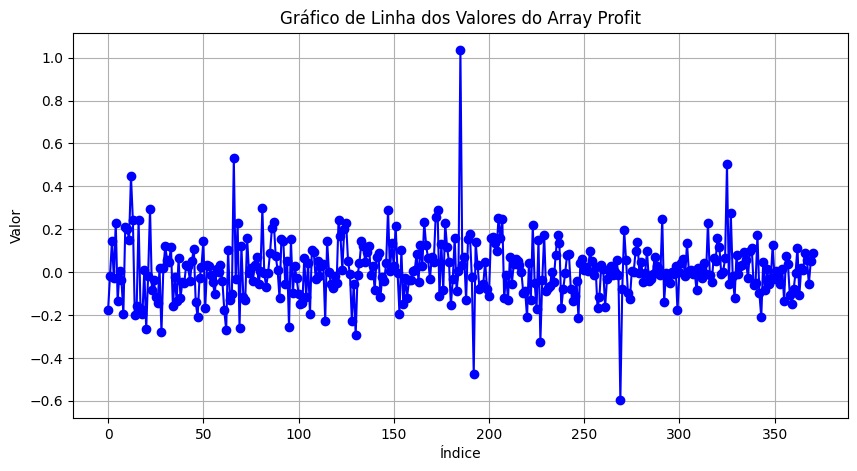

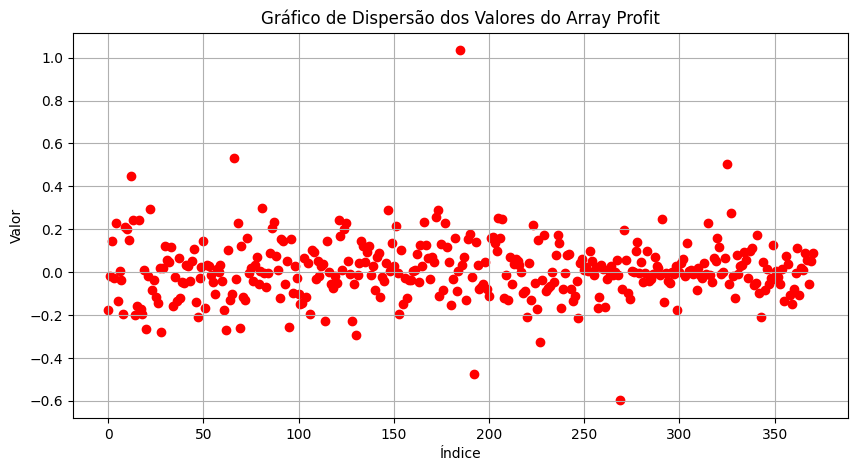

In [ ]:
# Gráfico de linha
plt.figure(figsize=(10, 5))  # Define o tamanho da figura
plt.plot(profit, marker='o', linestyle='-', color='b')
plt.title('Gráfico de Linha dos Valores do Array Profit')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

# Gráfico de dispersão (scatter plot)
plt.figure(figsize=(10, 5))
plt.scatter(range(len(profit)), profit, color='r')
plt.title('Gráfico de Dispersão dos Valores do Array Profit')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

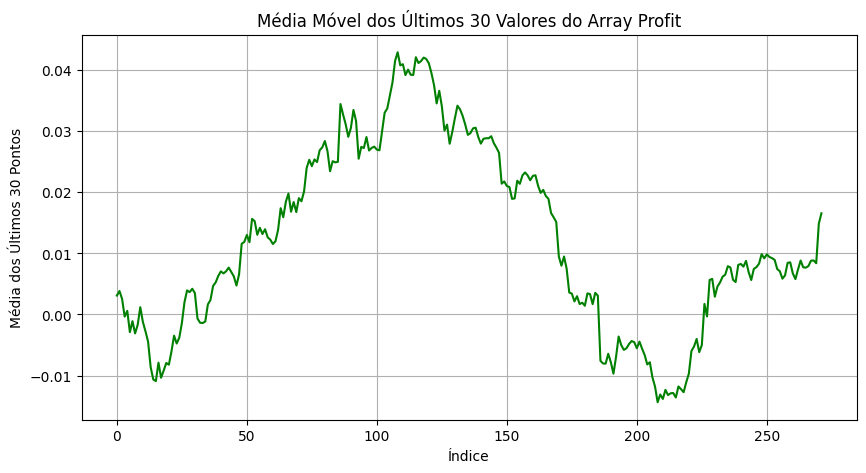

In [ ]:
# Tamanho da janela de média móvel
window_size = 100

# Calcular a média móvel
rolling_mean = np.convolve(profit, np.ones(window_size)/window_size, mode='valid')

# Gráfico da média móvel
plt.figure(figsize=(10, 5))
plt.plot(rolling_mean, linestyle='-', color='g')
plt.title('Média Móvel dos Últimos 30 Valores do Array Profit')
plt.xlabel('Índice')
plt.ylabel('Média dos Últimos 30 Pontos')
plt.grid(True)
plt.show()